# Emotional Sentiment through Mouse and Keyboard Dynamics
Ryan J Meneses, 2023

## Description
chillpill is an application that collects mouse and keyboard dynamics data from a user and uses it to predict their emotional state. This notebook analyzes the data collected from the application's data collection API and trains linear model to predict the user's emotional state.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from src.util import file

In [2]:
# load all of the datasets into an array
tracking_data = []
tracking_data_names = []
for filename in os.listdir(file.PREPROCESSED_PATH):
    if filename.endswith(".csv"):
        dataset = file.load_preprocessed_file(filename)
        tracking_data.append(dataset)
        tracking_data_names.append(filename)
        print(f"Loaded {filename} with {len(dataset)} rows.")

tracking_data[0].head()

Loaded 20230515-234755.csv with 100001 rows.
Loaded 20230511-183329.csv with 100000 rows.
Loaded 20230512-144915.csv with 100000 rows.
Loaded 20230515-222326.csv with 101554 rows.
Loaded 20230512-025044.csv with 100000 rows.
Loaded 20230512-134850.csv with 100011 rows.
Loaded 20230516-225422.csv with 100001 rows.
Loaded 20230510-224440.csv with 108139 rows.
Loaded 20230512-155539.csv with 100002 rows.
Loaded 20230512-015722.csv with 100001 rows.
Loaded 20230511-004806.csv with 100001 rows.
Loaded 20230514-004632.csv with 100004 rows.
Loaded 20230511-170741.csv with 105003 rows.
Loaded 20230512-124723.csv with 100005 rows.
Loaded 20230511-020011.csv with 100001 rows.
Loaded 20230516-143659.csv with 100003 rows.


,id,batch,time,x,y,scroll,press,release,feeling,input_type
0,1,1,1.684215e+09,260.535156,180.082031,0,0,0,1,1
1,2,1,1.684215e+09,264.531250,180.082031,0,0,0,1,1
2,3,1,1.684215e+09,269.839844,180.082031,0,0,0,1,1
3,4,1,1.684215e+09,273.835938,180.082031,0,0,0,1,1
4,5,1,1.684215e+09,277.832031,180.082031,0,0,0,1,1


In [3]:
tracking_data[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100001 entries, 0 to 100000
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          100001 non-null  int64  
 1   batch       100001 non-null  int64  
 2   time        100001 non-null  float64
 3   x           100001 non-null  float64
 4   y           100001 non-null  float64
 5   scroll      100001 non-null  int64  
 6   press       100001 non-null  int64  
 7   release     100001 non-null  int64  
 8   feeling     100001 non-null  int64  
 9   input_type  100001 non-null  int64  
dtypes: float64(3), int64(7)
memory usage: 7.6 MB


In [4]:
tracking_data[0].describe()

,id,batch,time,x,y,scroll,press,release,feeling,input_type
count,100001.000000,100001.000000,1.000010e+05,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000
mean,50000.999950,5.499995,1.684217e+09,463.279894,277.784785,0.194608,0.555154,0.558334,2.000000,1.648324
std,28867.946453,2.872282,1.632797e+03,390.957228,212.788986,0.395901,7.588224,7.608295,0.774597,1.208372
min,1.000000,1.000000,1.684215e+09,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,25001.000000,3.000000,1.684215e+09,73.855469,46.656250,0.000000,0.000000,0.000000,1.000000,1.000000
50%,50001.000000,5.000000,1.684216e+09,426.531250,283.085938,0.000000,0.000000,0.000000,2.000000,1.000000
75%,75001.000000,8.000000,1.684219e+09,771.187500,450.906250,0.000000,0.000000,0.000000,3.000000,1.000000
max,100001.000000,10.000000,1.684220e+09,1279.996094,799.996094,1.000000,122.000000,122.000000,3.000000,4.000000


## New Column and Data Preprocessing

From this point the dataset contains a new `batch` column, that indicates which batch the instances belong to. This batch is associated with a particular `feeling` "post-set" by the user as opposed to being "pre-set" as was initially done.

#### Pre-set vs. Post-set Feeling
Pre-set - the user selects how they are feeling and the feeling is set for each new row instance
Post-set - the user selects how they are feeling after each batch is collected or if they manually set how they're feeling, the program then loops through the entire batch and sets the feeling column.

##### Decision to use post-set over pre-set
Using post-set introduces less bias. During pre-setting, the user described that they felt their behavior change to act as the feeling they set; e.g., if the user said they felt great than they *acted* like they were great for the duration of the batch. In pre-setting, the user must reflect on how they were feeling during the batch that was already collected. 

While there may be minor fluctuations in a users emotional state over, e.g. a batch of 2500 instances, it is assumed that over that batch the feeling is about constant. This could lower the quality of a dataset, but given enough datasets might make up for some of the imprecision. Otherwise, *there may need some preprocessing here to separate good examples from bad.*

### New column: `input_type`
This will help the model distinguish between different kinds of input which could help the model associate different kinds behaviors with the same feeling based on the input type. As a simple example, the user may be more likely to use the mouse when they are feeling happy and more likely to use the keyboard when they are feeling sad. 

### Preprocessing the old datasets to include the new column
The follow code block will add the new column to the old datasets and save them to a new directory. This column will be added by checking the for non-zero values associated with a mouse_motion, mouse_click, keyboard_input, and scrolling event.

`mouse_motion` - associated with `x` and `y` columns
`mouse_click`/`keyboard_click` - currently there is no way to distinguish between as they are both associated with the `press` and `release` columns. So for now they will both be given a keyboard_input value.
`scrolling` - associated with `scroll` column

Encoding
- 1: mouse_motion
- 2: mouse_click
- 3: keyboard_input
- 4: scrolling

In [5]:
# # loop through the dataframe and set input_type to 1 where x or y is not 0, to 3 where press or release is not 0, to 4 where scroll is not 0, or 0 otherwise for all dataframes in the tracking_data array
# for dataframe in tracking_data:
#     for index, row in dataframe.iterrows():
#         if row["x"] != 0 or row["y"] != 0:
#             dataframe.at[index, "input_type"] = 1
#         elif row["press"] != 0 or row["release"] != 0:
#             dataframe.at[index, "input_type"] = 3
#         elif row["scroll"] != 0:
#             dataframe.at[index, "input_type"] = 4
#         else:
#             dataframe.at[index, "input_type"] = 0


# # convert the input_type column to an integer
# for dataframe in tracking_data:
#     dataframe["input_type"] = dataframe["input_type"].astype(int)

# # write all of the dataframes to csv files with the same names in the preprocessed folder
# for dataframe, filename in zip(tracking_data, tracking_data_names):
#     file.write_preprocessed_file_from_dataframe(filename, dataframe)

In [6]:
# show the first 1000 rows of the first dataframe in the tracking_data array
tracking_data[0][:1000]

,id,batch,time,x,y,scroll,press,release,feeling,input_type
0,1,1,1.684215e+09,260.535156,180.082031,0,0,0,1,1
1,2,1,1.684215e+09,264.531250,180.082031,0,0,0,1,1
2,3,1,1.684215e+09,269.839844,180.082031,0,0,0,1,1
3,4,1,1.684215e+09,273.835938,180.082031,0,0,0,1,1
4,5,1,1.684215e+09,277.832031,180.082031,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
995,996,1,1.684215e+09,748.855469,530.117188,0,0,0,1,1
996,997,1,1.684215e+09,752.851562,529.316406,0,0,0,1,1
997,998,1,1.684215e+09,756.847656,529.316406,0,0,0,1,1
998,999,1,1.684215e+09,759.703125,528.601562,0,0,0,1,1


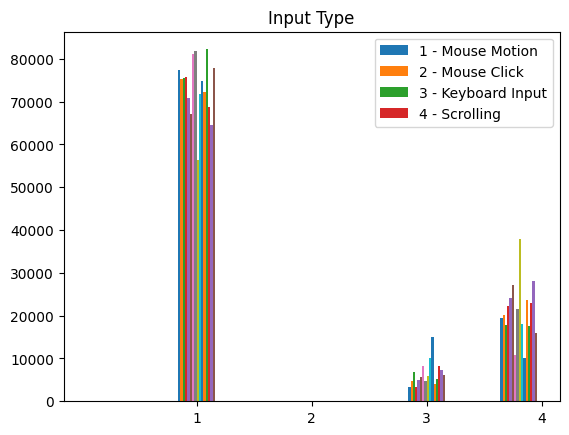

In [7]:
# combine the input_type for all of the dataframes in the tracking_data array into a single histogram
plt.hist([dataframe["input_type"] for dataframe in tracking_data])
plt.xticks(range(1, 5))

plt.title("Input Type")

# add a legend for the input_type values decoded into Mouse Motion, Mouse Click, Keyboard Input, and Scrolling
plt.legend(
    [
        "1 - Mouse Motion",
        "2 - Mouse Click",
        "3 - Keyboard Input",
        "4 - Scrolling",
    ],
)

In [8]:
# separate input_type 1 from the first dataframe in the tracking_data array into a new dataframe
input_type_1 = tracking_data[0][tracking_data[0]["input_type"] == 1]
input_type_1.head()

,id,batch,time,x,y,scroll,press,release,feeling,input_type
0,1,1,1.684215e+09,260.535156,180.082031,0,0,0,1,1
1,2,1,1.684215e+09,264.531250,180.082031,0,0,0,1,1
2,3,1,1.684215e+09,269.839844,180.082031,0,0,0,1,1
3,4,1,1.684215e+09,273.835938,180.082031,0,0,0,1,1
4,5,1,1.684215e+09,277.832031,180.082031,0,0,0,1,1


Text(0.5, 1.0, 'Mouse Motion Feeling')

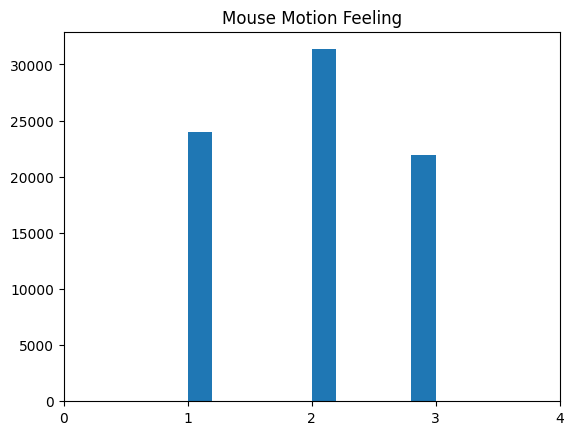

In [9]:
# create a histogram of the input_type 1 dataframe with respect to feeling
plt.hist(input_type_1["feeling"])
plt.xticks(range(5))

plt.title("Mouse Motion Feeling")

In [10]:
# # save input_type 1 dataframe to a csv file in the preprocessed folder with the same name as the original file with mouse-motion- prepended
# file.write_preprocessed_file_by_input_type_from_dataframe(
#     1, "mouse-motion-" + tracking_data_names[0], input_type_1
# )

Text(0, 0.5, 'Y')

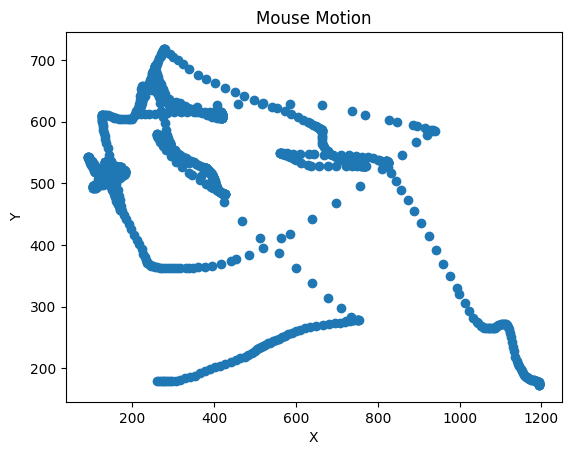

In [11]:
# create an x vs y scatter plot of the input_type 1 dataframe for the first 1000 rows
plt.scatter(
    input_type_1["x"][:1000],
    input_type_1["y"][:1000],
)
plt.title("Mouse Motion")

# label the x and y axes
plt.xlabel("X")
plt.ylabel("Y")